## Import Libraries

In [30]:
# Import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import seaborn as sns
from tensorflow import keras
from keras.layers import *
from keras.models import *
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
import os, shutil
import warnings
warnings.filterwarnings('ignore')

## Load the data and visualise the images

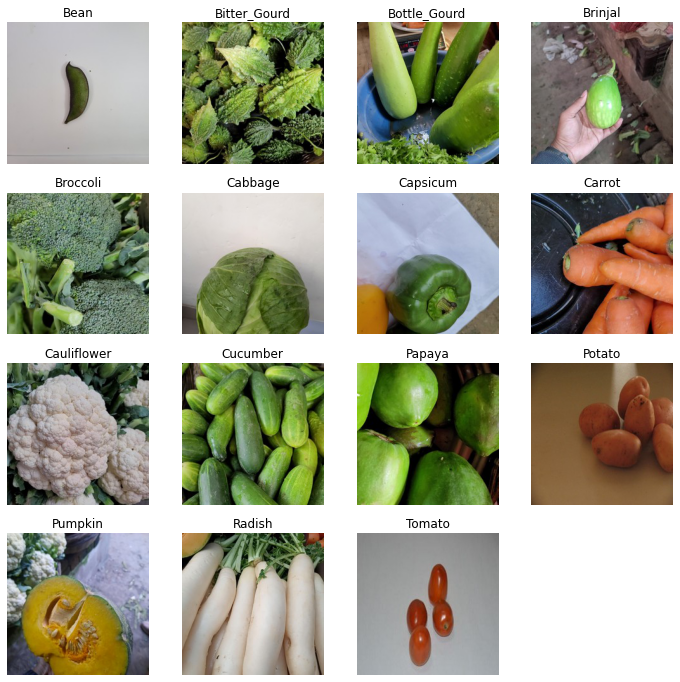

In [2]:
# Let's plot a few images
train_path = "Vegetable Images/train"
validation_path = "Vegetable Images/validation"
test_path = "Vegetable Images/test"

image_categories = os.listdir('Vegetable Images/train')

def plot_images(image_categories):
    
    # Create a figure
    plt.figure(figsize=(12, 12))
    for i, cat in enumerate(image_categories):
        
        # Load images for the ith category
        image_path = train_path + '/' + cat
        images_in_folder = os.listdir(image_path)
        first_image_of_folder = images_in_folder[0]
        first_image_path = image_path + '/' + first_image_of_folder
        img = image.load_img(first_image_path)
        img_arr = image.img_to_array(img)/255.0
        
        # Create Subplot and plot the images
        plt.subplot(4, 4, i+1)
        plt.imshow(img_arr)
        plt.title(cat)
        plt.axis('off')
        
    plt.show()

# Call the function
plot_images(image_categories)

## Prepare the Dataset

In [3]:
# Creating Image Data Generator for train, validation and test set

# 1. Train Set
train_gen = ImageDataGenerator(rescale = 1./255,
                                      rotation_range=40,
                                      width_shift_range=0.2,
                                      height_shift_range=0.2,
                                      shear_range=0.2,
                                      zoom_range=0.2,
                                      horizontal_flip=True,
                                      fill_mode='nearest')

train_image_generator = train_gen.flow_from_directory(
                                            train_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

# 2. Validation Set
val_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
val_image_generator = train_gen.flow_from_directory(
                                            validation_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

# 3. Test Set
test_gen = ImageDataGenerator(rescale = 1.0/255.0) # Normalise the data
test_image_generator = train_gen.flow_from_directory(
                                            test_path,
                                            target_size=(150, 150),
                                            batch_size=32,
                                            class_mode='categorical')

Found 15000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.
Found 3000 images belonging to 15 classes.


In [4]:
# Print the class encodings done by the generators
class_map = dict([(v, k) for k, v in train_image_generator.class_indices.items()])
print(class_map)

{0: 'Bean', 1: 'Bitter_Gourd', 2: 'Bottle_Gourd', 3: 'Brinjal', 4: 'Broccoli', 5: 'Cabbage', 6: 'Capsicum', 7: 'Carrot', 8: 'Cauliflower', 9: 'Cucumber', 10: 'Papaya', 11: 'Potato', 12: 'Pumpkin', 13: 'Radish', 14: 'Tomato'}


## Build a model

In [11]:
model= Sequential()
model.add(Conv2D(filters=64,activation="relu",kernel_size=3,input_shape=(150,150,3)))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=64, activation="relu",kernel_size=3))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=128, activation="relu",kernel_size=3))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Conv2D(filters=128, activation="relu",kernel_size=3))
model.add(MaxPool2D(pool_size=2, strides=2))
model.add(Flatten())
model.add(Dropout(0.2))
model.add(Dense(units=512, activation="relu"))
model.add(Dense(units=15,activation="softmax"))

model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_6 (Conv2D)            (None, 148, 148, 64)      1792      
_________________________________________________________________
max_pooling2d_6 (MaxPooling2 (None, 74, 74, 64)        0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 72, 72, 64)        36928     
_________________________________________________________________
max_pooling2d_7 (MaxPooling2 (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_8 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_8 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_9 (Conv2D)            (None, 15, 15, 128)      

## Train the model

In [12]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", min_delta=1e-2, patience=10, verbose=1, restore_best_weights=True)
reduce_lr_on_plateau = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_accuracy", factor=1e-1, patience=5, verbose=1, min_delta=1e-2)

In [13]:
model.compile(optimizer="Adam", loss='categorical_crossentropy', metrics=['accuracy'])
hist = model.fit(
    train_image_generator,
    epochs=50,
    verbose=1,
    validation_data=val_image_generator,
    steps_per_epoch= 15000//32,
    validation_steps = 3000//32,
    callbacks= [early_stop,reduce_lr_on_plateau]
)

Epoch 1/50
468/468 [==============================] - 578s 1s/step - loss: 1.5919 - accuracy: 0.4411 - val_loss: 1.0619 - val_accuracy: 0.6435
Epoch 2/50
468/468 [==============================] - 450s 961ms/step - loss: 0.8275 - accuracy: 0.7112 - val_loss: 0.6251 - val_accuracy: 0.7954
Epoch 3/50
468/468 [==============================] - 443s 946ms/step - loss: 0.5301 - accuracy: 0.8169 - val_loss: 0.4476 - val_accuracy: 0.8545
Epoch 4/50
468/468 [==============================] - 451s 964ms/step - loss: 0.4090 - accuracy: 0.8651 - val_loss: 0.3495 - val_accuracy: 0.8814
Epoch 5/50
468/468 [==============================] - 447s 956ms/step - loss: 0.3110 - accuracy: 0.9013 - val_loss: 0.2943 - val_accuracy: 0.9056
Epoch 6/50
468/468 [==============================] - 465s 993ms/step - loss: 0.2661 - accuracy: 0.9133 - val_loss: 0.2380 - val_accuracy: 0.9264
Epoch 7/50
468/468 [==============================] - 447s 954ms/step - loss: 0.2388 - accuracy: 0.9240 - val_loss: 0.1905 - va

## Model Trained for 12 Epochs

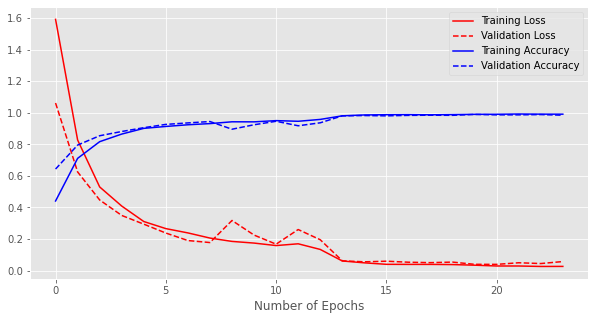

In [14]:
# Plot the error and accuracy
h = hist.history
plt.style.use('ggplot')
plt.figure(figsize=(10, 5))
plt.plot(h['loss'], c='red', label='Training Loss')
plt.plot(h['val_loss'], c='red', linestyle='--', label='Validation Loss')
plt.plot(h['accuracy'], c='blue', label='Training Accuracy')
plt.plot(h['val_accuracy'], c='blue', linestyle='--', label='Validation Accuracy')
plt.xlabel("Number of Epochs")
plt.legend(loc='best')
plt.show()

In [15]:
def visualize_metrics(hist):
  plt.figure(figsize=(12, 5))

  plt.subplot(121)
  plt.plot(hist.epoch, hist.history['loss'], label='Loss')
  plt.plot(hist.epoch, hist.history['val_loss'], label='Val Loss', color='orange')
  plt.legend()

  plt.subplot(122)
  plt.plot(hist.epoch, hist.history['accuracy'], label='Acc')
  plt.plot(hist.epoch, hist.history['val_accuracy'], label='Val Acc', color='orange')
  plt.legend()

  return plt.show()

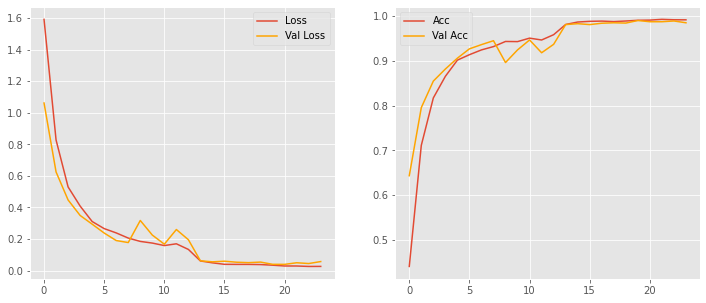

In [16]:
visualize_metrics(hist)

## Evaluate the model using test dataset

In [17]:
# Predict the accuracy for the test set
model.evaluate(test_image_generator)

94/94 [==============================] - 56s 597ms/step - loss: 0.0730 - accuracy: 0.9777


[0.07302052527666092, 0.9776666760444641]

## Saving the model

In [18]:
model.save("sayur_modelfix.h5")
model.save_weights("sayur_weightsfix.h5")

In [19]:
from tensorflow.keras.models import Sequential, model_from_json
# serialize model to JSON
model_json = model.to_json()
with open("sayur_modelfix.json", "w") as json_file:
    json_file.write(model_json)
# serialize weights to HDF5
model.save_weights("sayur_weightsfix.h5")

# load json and create model
json_file = open('sayur_modelfix.json', 'r')
loaded_model_json = json_file.read()
json_file.close()
loaded_model = model_from_json(loaded_model_json)
# load weights into new model
loaded_model.load_weights("sayur_weightsfix.h5")
print("Loaded model from disk")

Loaded model from disk


## Predicting another Images

In [31]:
def predicting_image(im_upload, model = model):
  imz = im_upload
  imz_array = np.asarray(imz)
  imz_array = imz_array*(1/225)
  imz_input = tf.reshape(imz_array, shape = [1, 150, 150, 3])

  predicted_array = model.predict(imz_input)[0]

  df = pd.DataFrame(predicted_array)
  df = df.rename({0:'Probability'}, axis = 'columns')
  produk = ['Bean', 'Bitter_Gourd', 'Bottle_Gourd',"Brinjal",
            "Broccoli","Cabbage","Capsicum","Carrot","Cauliflower",
           "Cucumber","Papaya","Potato","Pumpkin","Radish","Tomato"]
  df['Product'] = produk
  df = df[['Product', 'Probability']]

  predict_label = np.argmax(model.predict(imz_input))

  if predict_label == 0:
      predict_product = 'Bean'
  elif predict_label == 1:
      predict_product = 'Bitter_Gourd'
  elif predict_label == 2:
      predict_product = 'Bottle_Gourd'
  elif predict_label == 3:
      predict_product = 'Brinjal'
  elif predict_label == 4:
      predict_product = 'Broccoli'
  elif predict_label == 5:
      predict_product = 'Cabbage'
  elif predict_label == 6:
      predict_product = 'Capsicum'
  elif predict_label == 7:
      predict_product = 'Carrot'
  elif predict_label == 8:
      predict_product = 'Cauliflower' 
  elif predict_label == 9:
      predict_product = 'Cucumber'
  elif predict_label == 10:
      predict_product = 'Papaya'
  elif predict_label == 11:
      predict_product = 'Potato'
  elif predict_label == 12:
      predict_product = 'Pumpkin'
  elif predict_label == 13:
      predict_product = 'Radish'
  elif predict_label == 14:
      predict_product = 'Tomato'
  
  return predict_product, df

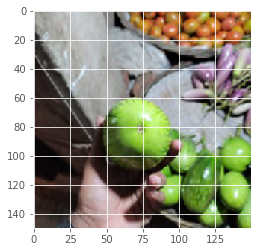


The image is detected as Brinjal


         Product   Probability
0           Bean  3.438488e-07
1   Bitter_Gourd  3.250800e-15
2   Bottle_Gourd  3.614649e-09
3        Brinjal  9.999994e-01
4       Broccoli  1.361371e-11
5        Cabbage  4.068212e-11
6       Capsicum  2.189082e-12
7         Carrot  1.143130e-21
8    Cauliflower  7.977453e-12
9       Cucumber  2.696330e-07
10        Papaya  9.868663e-09
11        Potato  1.447473e-14
12       Pumpkin  4.156012e-15
13        Radish  1.275258e-14
14        Tomato  3.493397e-12




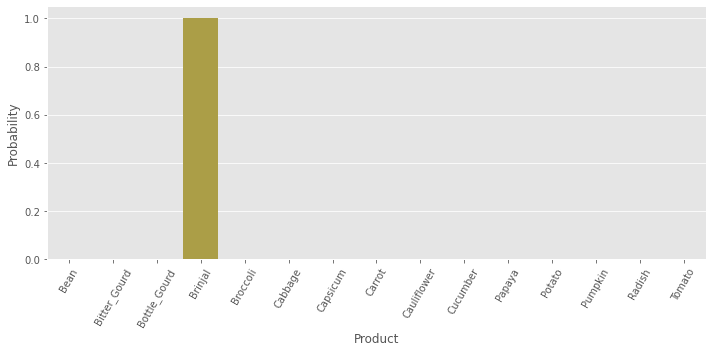

In [37]:
imx_path = "Vegetable Images/test/Brinjal/1120.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

label, df = predicting_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Product"], y=df['Probability'])
plt.xticks(rotation=60)
plt.tight_layout()

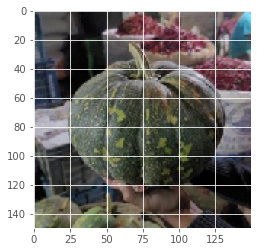


The image is detected as Pumpkin


         Product   Probability
0           Bean  8.742150e-13
1   Bitter_Gourd  4.508321e-09
2   Bottle_Gourd  1.893386e-14
3        Brinjal  8.437710e-11
4       Broccoli  7.723576e-06
5        Cabbage  3.080877e-05
6       Capsicum  1.150284e-11
7         Carrot  5.934025e-10
8    Cauliflower  5.453314e-08
9       Cucumber  8.265700e-13
10        Papaya  2.217741e-12
11        Potato  3.011698e-08
12       Pumpkin  9.999614e-01
13        Radish  3.588707e-14
14        Tomato  2.289170e-08




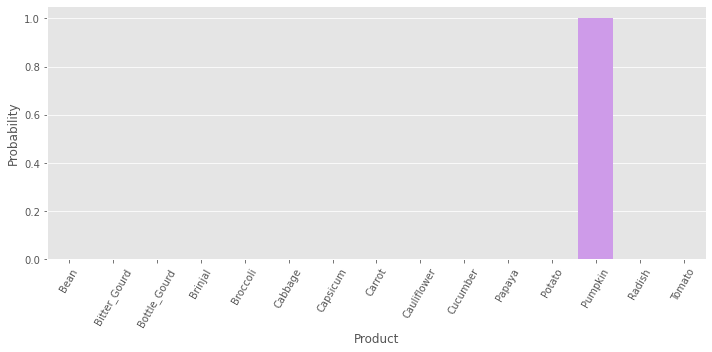

In [38]:
imx_path = "Vegetable Images/test/Pumpkin/1092.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

label, df = predicting_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Product"], y=df['Probability'])
plt.xticks(rotation=60)
plt.tight_layout()

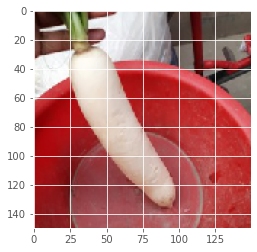


The image is detected as Radish


         Product   Probability
0           Bean  1.976217e-13
1   Bitter_Gourd  7.228333e-12
2   Bottle_Gourd  1.360236e-14
3        Brinjal  1.893944e-18
4       Broccoli  1.017797e-13
5        Cabbage  9.926526e-15
6       Capsicum  1.141547e-06
7         Carrot  8.655388e-09
8    Cauliflower  1.235974e-15
9       Cucumber  1.253655e-18
10        Papaya  4.649222e-11
11        Potato  2.232743e-08
12       Pumpkin  1.203619e-13
13        Radish  9.999987e-01
14        Tomato  1.151660e-07




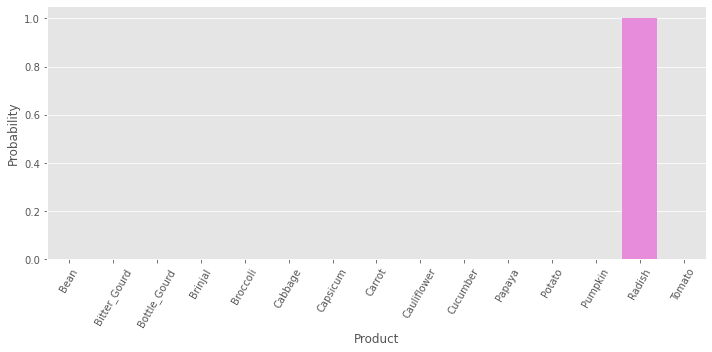

In [39]:
imx_path = "Vegetable Images/test/Radish/1074.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

label, df = predicting_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Product"], y=df['Probability'])
plt.xticks(rotation=60)
plt.tight_layout()

## Images from Internet

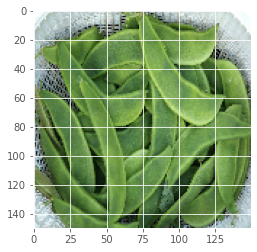


The image is detected as Bean


         Product   Probability
0           Bean  9.911746e-01
1   Bitter_Gourd  1.428842e-04
2   Bottle_Gourd  4.610543e-06
3        Brinjal  1.295696e-04
4       Broccoli  5.400392e-04
5        Cabbage  3.278265e-03
6       Capsicum  4.683832e-06
7         Carrot  1.792127e-12
8    Cauliflower  3.893253e-06
9       Cucumber  4.711899e-03
10        Papaya  3.928726e-08
11        Potato  4.549878e-13
12       Pumpkin  2.691587e-06
13        Radish  4.055935e-08
14        Tomato  6.774255e-06




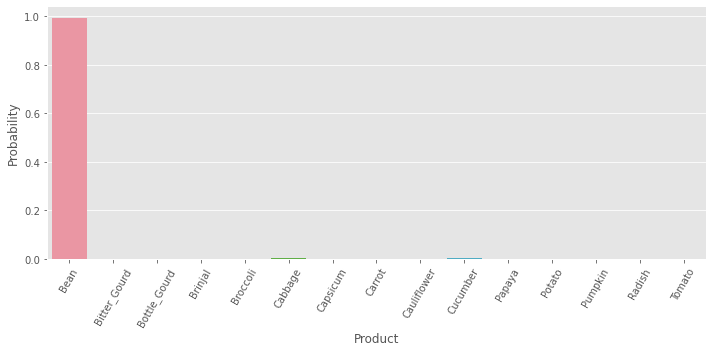

In [41]:
# https://m.media-amazon.com/images/I/71-ZJyXbZQL._SL1417_.jpg
imx_path = "71-ZJyXbZQL._SL1417_.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

label, df = predicting_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Product"], y=df['Probability'])
plt.xticks(rotation=60)
plt.tight_layout()

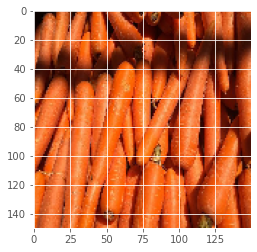


The image is detected as Carrot


         Product   Probability
0           Bean  5.186613e-17
1   Bitter_Gourd  3.138512e-12
2   Bottle_Gourd  1.870274e-16
3        Brinjal  3.046899e-19
4       Broccoli  2.127259e-09
5        Cabbage  5.243283e-12
6       Capsicum  1.423154e-10
7         Carrot  9.999866e-01
8    Cauliflower  2.749088e-10
9       Cucumber  1.700247e-18
10        Papaya  1.211863e-07
11        Potato  2.187094e-08
12       Pumpkin  7.756164e-09
13        Radish  2.826009e-07
14        Tomato  1.303780e-05




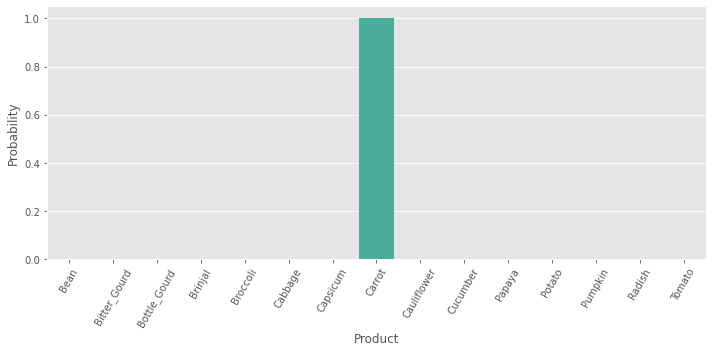

In [44]:
# https://assets.pikiran-rakyat.com/crop/0x0:0x0/750x500/photo/2021/07/17/582932815.jpg
imx_path = "582932815.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

label, df = predicting_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Product"], y=df['Probability'])
plt.xticks(rotation=60)
plt.tight_layout()

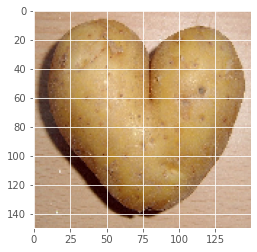


The image is detected as Potato


         Product   Probability
0           Bean  1.259936e-22
1   Bitter_Gourd  2.560345e-19
2   Bottle_Gourd  9.869253e-17
3        Brinjal  9.144165e-15
4       Broccoli  9.233228e-16
5        Cabbage  3.120856e-08
6       Capsicum  2.818219e-18
7         Carrot  9.532066e-12
8    Cauliflower  8.494721e-07
9       Cucumber  3.623366e-15
10        Papaya  7.635070e-10
11        Potato  9.999775e-01
12       Pumpkin  2.170288e-05
13        Radish  2.972658e-12
14        Tomato  2.305146e-08




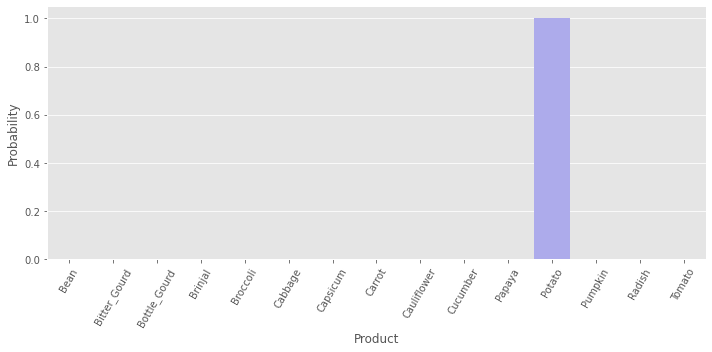

In [43]:
# https://upload.wikimedia.org/wikipedia/commons/thumb/4/4c/Potato_heart_mutation.jpg/878px-Potato_heart_mutation.jpg
imx_path = "878px-Potato_heart_mutation.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

label, df = predicting_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Product"], y=df['Probability'])
plt.xticks(rotation=60)
plt.tight_layout()

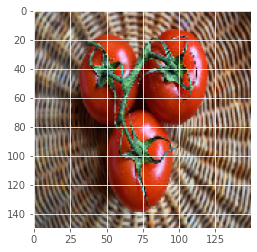


The image is detected as Tomato


         Product   Probability
0           Bean  1.563767e-15
1   Bitter_Gourd  5.990355e-13
2   Bottle_Gourd  2.082389e-17
3        Brinjal  1.830656e-17
4       Broccoli  5.332187e-11
5        Cabbage  3.955740e-15
6       Capsicum  1.703208e-13
7         Carrot  7.092259e-14
8    Cauliflower  1.710522e-11
9       Cucumber  3.595940e-20
10        Papaya  9.997134e-17
11        Potato  2.161925e-24
12       Pumpkin  1.119852e-12
13        Radish  1.293618e-22
14        Tomato  1.000000e+00




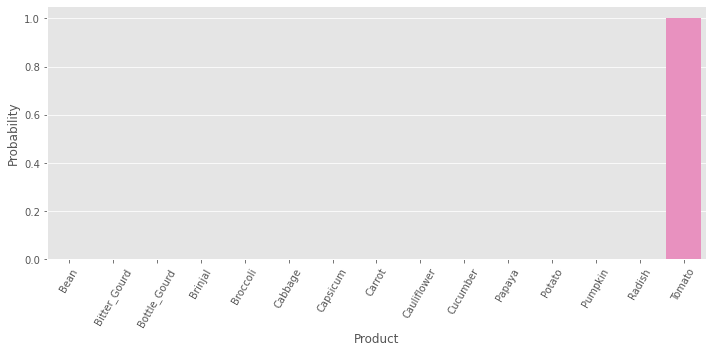

In [48]:
# https://cdn.pixabay.com/photo/2018/07/06/08/49/tomatoes-3520004__340.jpg
imx_path = "tomatoes-3520004__340.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

label, df = predicting_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Product"], y=df['Probability'])
plt.xticks(rotation=60)
plt.tight_layout()

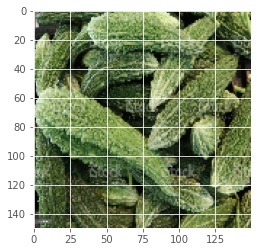


The image is detected as Bitter_Gourd


         Product   Probability
0           Bean  2.292630e-06
1   Bitter_Gourd  9.919193e-01
2   Bottle_Gourd  9.929809e-13
3        Brinjal  1.740114e-09
4       Broccoli  6.108214e-03
5        Cabbage  1.577541e-09
6       Capsicum  3.629856e-14
7         Carrot  1.712355e-14
8    Cauliflower  9.271326e-09
9       Cucumber  6.307011e-11
10        Papaya  6.330722e-06
11        Potato  1.522697e-15
12       Pumpkin  1.609980e-03
13        Radish  3.537605e-04
14        Tomato  4.802662e-11




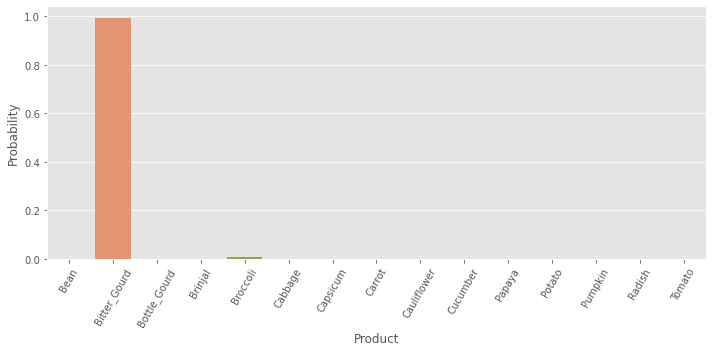

In [49]:
# https://media.istockphoto.com/photos/green-bitter-melon-bitter-gourd-or-karela-is-a-unique-vegetable-fruit-picture-id1175076984
imx_path = "istockphoto-1175076984-1024x1024.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

label, df = predicting_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Product"], y=df['Probability'])
plt.xticks(rotation=60)
plt.tight_layout()

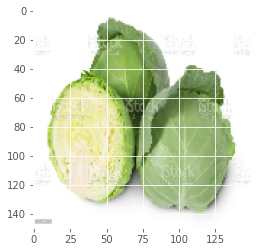


The image is detected as Cabbage


         Product   Probability
0           Bean  1.398185e-06
1   Bitter_Gourd  3.431086e-05
2   Bottle_Gourd  3.466490e-06
3        Brinjal  2.553725e-04
4       Broccoli  4.488116e-03
5        Cabbage  9.328385e-01
6       Capsicum  1.832193e-07
7         Carrot  2.686004e-10
8    Cauliflower  2.718423e-02
9       Cucumber  9.064345e-05
10        Papaya  1.182759e-05
11        Potato  8.069898e-10
12       Pumpkin  6.369886e-05
13        Radish  5.855883e-10
14        Tomato  3.502831e-02




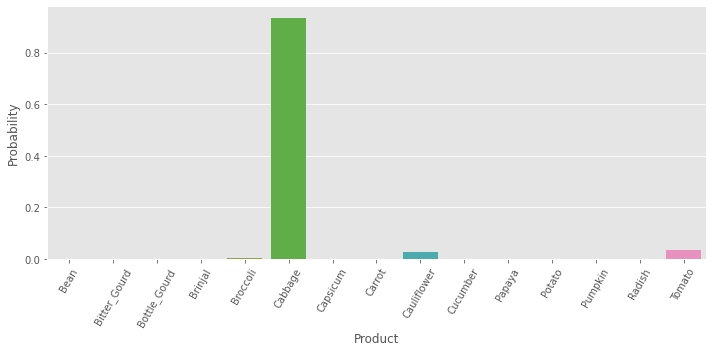

In [50]:
# https://media.istockphoto.com/photos/group-of-green-heads-of-white-cabbage-with-sliced-one-picture-id1224318250
imx_path = "istockphoto-1224318250-1024x1024.jpg"
img = image.load_img(imx_path, target_size=(150,150))
imgplot = plt.imshow(img)
x = image.img_to_array(img)
x = np.expand_dims(x, axis=0)
img = np.vstack([x])

label, df = predicting_image(img)

print('\n')
plt.show()
print("\nThe image is detected as " + label)
print('\n')
print(df)
print('\n')
plt.figure(figsize=(10, 5))
sns.barplot(x=df["Product"], y=df['Probability'])
plt.xticks(rotation=60)
plt.tight_layout()